In [1]:
import os
import glob
import time
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import hashlib

Обучение моделей только на одном эксгаустере

In [3]:
# не используем фичи, которые сильно коррелируют между собой
with open('/root/sep_data/correlated_features.json', 'rb') as f:
    remove = json.loads( f.read().decode('utf-8') )

In [5]:
# цикл по эксгаустерам
for exh in range(4, 10):
    X_exh = pd.read_parquet( '/root/sep_data/X_exhauster%s_train.parquet' % exh )
    

    cols = [x for x in X_exh.columns if x not in remove]

    # делаем роллинг с окном в 30 дней
    # с окном в 1 месяц роллинг не работает, тк тут нужны точные границы
    x1 = X_exh[ cols ].rolling(window='30D').agg(['max', 'sem', 'kurt', 'std', 'skew']).fillna(0)

    y_exh = pd.read_parquet('/root/sep_data/Y_exhauster%s_train.parquet' % exh )

    skipped_targets = []
    index_to_name = {}
    # цикл по таргетам
    for x in range(len(y_exh.columns)):
        col = y_exh.columns[x]
    
        label_0 = y_exh[[ col ]][ y_exh[ col ] == 0 ].count().values[0]
        label_2 = y_exh[[ col ]][ y_exh[ col ] == 2 ].count().values[0]
        attitude = label_2/(label_0+label_2)

        # если мало примеров, не смотрим такой таргет
        if attitude < 0.07:
            skipped_targets.append((col, attitude))
            print('Skipped target: %s' % col)
            continue
    
        index_to_name[col] = hashlib.sha256(col.encode('utf-8')).hexdigest() 
    
        print('Processing target: %s' % col )
        start = time.time()
        splitted_data = train_test_split(x1, y_exh[col].map({0: 0, 1: 1, 2: 1}), test_size=0.3)
        X_train, X_test, y_train, y_test = splitted_data
    
        train_pool = Pool(X_train, y_train)
        test_pool = Pool(X_test, y_test)
        model = CatBoostClassifier(learning_rate=0.01, iterations=100, depth=4, loss_function='Logloss', eval_metric='Accuracy')
        model.fit(train_pool, eval_set=test_pool, verbose=False)
        print('Accuracy', model.best_score_.get('learn').get('Accuracy'))
        
        # сохраняем модель
        model.save_model('/root/sep_models/%s_exh%s.cb' % (hashlib.sha256(col.encode('utf-8')).hexdigest() , exh) )
        print('Done. Spended time: %s' % (time.time() - start) ) 
    
    itn = json.dumps(index_to_name)
    with open('/root/sep_models/exh%s_index_to_target.json' % exh, 'wb') as f:
        f.write( itn.encode('utf-8') )
        

Processing target: Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4
Accuracy 0.9884478178437814
Done. Spended time: 30.975902318954468
Processing target: Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4
Accuracy 0.999669600979291
Done. Spended time: 30.835909366607666
Processing target: Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4
Accuracy 0.996819201646394
Done. Spended time: 27.619210958480835
Processing target: Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4
Accuracy 0.9817236851106041
Done. Spended time: 30.62529993057251
Skipped target: Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4
Processing target: Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4
Accuracy 0.9992557987782735
Done. Spended time: 31.413180112838745
Processing target: Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
Accuracy 0.9994982036179229
Done. Spended time: 30.51780390739441
Processing target: Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4
Accuracy 0.9629420540718886
Done. Spended time: 29.249083042144775
Processin

Делаем предсказания

In [5]:
# интервалы к эксгуастеру в тестовом файле
target_col_data = {
    "exhauster4": slice(93,116), 
    "exhauster5": slice(28,62),
    "exhauster6": slice(148,175),
    "exhauster7": slice(116,148),
    "exhauster8": slice(62,93),
    "exhauster9": slice(0,28),
}

In [6]:
with open('/root/model/Y_columns.json', 'rb') as f:
    Y_columns = json.loads( f.read().decode('utf-8') ) 

In [7]:
y_result = pd.read_parquet('/root/sep_data/X_exhauster4_test.parquet').reset_index()[['DT']].copy()

In [15]:
# цикл по эксгаустерам
for x in target_col_data:
    print(x)
    # цикл по таргетам
    for y in Y_columns[ target_col_data[ x ] ]:
        pt = y

        # если модель найдена, восстанавливаем ее
        if os.path.exists('/root/sep_models/%s_exh%s.cb' % (hashlib.sha256(pt.encode('utf-8')).hexdigest(), x[-1]) ):
            print(pt)
            
    
            model = CatBoostClassifier(learning_rate=0.01, iterations=100, depth=3, loss_function='Logloss', eval_metric='Accuracy')
            model = model.load_model('/root/sep_models/%s_exh%s.cb' % (hashlib.sha256(pt.encode('utf-8')).hexdigest(), x[-1]) )

            df = pd.read_parquet('/root/sep_data/X_%s_test.parquet' % x)
            
            cols = [x for x in df.columns if x not in remove]
            x1 = df[ cols ].rolling(window='30D').agg(['max', 'sem', 'kurt', 'std', 'skew']).fillna(0)

            # берем именно вероятности по каждому классу
            y_pred = model.predict_proba(x1)

            # у нас бинарная классификация, по этому достаточно сохранить только один класс
            y_result[y] = y_pred[:,1]


exhauster4
Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4
Y_ЭКСГАУСТЕР А/М №4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4
Y_ЭКСГАУСТЕР А/М №4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4
Y_ЭКСГАУСТЕР А/М №4_ТР-Р ТМ-4000-10/6 ЭКСГ. №4
exhauster5
Y_ЭКСГАУСТЕР А/М №5_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №5
Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5
Y_ЭКСГАУСТЕР А/М №5_КОРПУС ЭКСГ. №5
Y_ЭКСГАУСТЕР А/М №5_ЗАДВИЖКА ЭКСГ. №5
Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №5
Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №2
Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №

In [16]:
y_result.to_parquet('/root/sep_data/sep_y_pred.parquet')

In [17]:
yy = y_result.copy()
yy.index = yy['DT']
del yy['DT']

<Axes: xlabel='DT'>

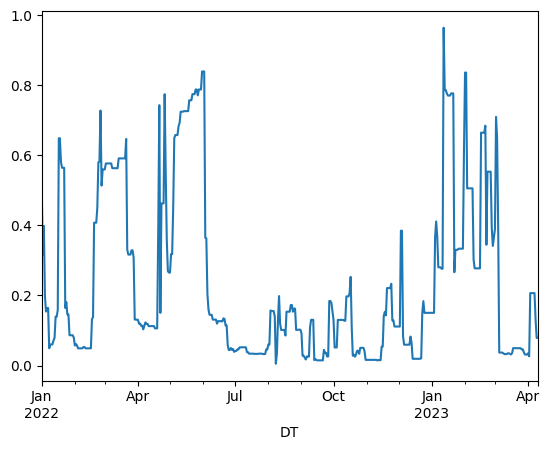

In [27]:
yy.resample('1D')['Y_ЭКСГАУСТЕР А/М №7_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ7 ВУ1'].max().plot()